In [ ]:
#pip install yfinance

In [ ]:
#pip install pandas_datareader

In [1]:
# Import dependencies
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot
import hvplot.pandas
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
import yfinance as yf
from pandas_datareader import data as pdr
from datetime import datetime

In [2]:
# Set the ticker symbol
ticker = "AAPL"

# Establish the timeframe
start = '2000-01-03'
end = '2021-01-03'

# Pull the historical stock data from 01/03/2000 to 01/03/2021
yf.pdr_override()
ticker_data = pdr.get_data_yahoo(ticker, start=start, end=end)

# Dropping the dividends and stock split columns
trading_signals = ticker_data.drop(columns=['Open', 'High', 'Low','Volume','Adj Close'])
trading_signals.head()

[*********************100%***********************]  1 of 1 completed


Close
Date                
2000-01-03  0.999442
2000-01-04  0.915179
2000-01-05  0.928571
2000-01-06  0.848214
2000-01-07  0.888393

# Generate Trading Signals

In [3]:
# Set the windows
short_window = 50
long_window = 100

# Generate the short (50 days) and long moving averages(100 days) 
trading_signals["SMA50"] = trading_signals["Close"].rolling(window=short_window).mean()
trading_signals["SMA100"] = trading_signals["Close"].rolling(window=long_window).mean()
trading_signals["Signal"] = 0.0

# Generate the trading signal 0 or 1,
# where 0 is when the SMA50 is under the SMA100, and
# where 1 is when the SMA50 is higher (or crosses over) the SMA100
trading_signals["Signal"][short_window:] = np.where(
    trading_signals["SMA50"][short_window:] > trading_signals["SMA100"][short_window:], 1.0, 0.0
)

# Calculate the points in time at which a position should be taken, 1 or -1
trading_signals["Entry/Exit"] = trading_signals["Signal"].diff()

trading_signals.tail(10)

Close     SMA50      SMA100  Signal  Entry/Exit
Date                                                            
2020-12-17  128.699997  118.7156  116.887450     1.0         0.0
2020-12-18  126.660004  118.9494  117.203650     1.0         0.0
2020-12-21  128.229996  119.1746  117.524050     1.0         0.0
2020-12-22  131.880005  119.3242  117.780250     1.0         0.0
2020-12-23  130.960007  119.5214  118.000475     1.0         0.0
2020-12-24  131.970001  119.7370  118.223525     1.0         0.0
2020-12-28  136.690002  120.0566  118.489800     1.0         0.0
2020-12-29  134.869995  120.3736  118.699475     1.0         0.0
2020-12-30  133.720001  120.7284  118.925550     1.0         0.0
2020-12-31  132.690002  121.0320  119.125175     1.0         0.0

In [4]:
# Visualize exit point compared to closing price
exit = trading_signals[trading_signals['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in USD $',
    width=1100,
    height=600
)
# Visualize entry point compared to the closing price
entry = trading_signals[trading_signals['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in USD $',
    width=1100,
    height=600
)
# Visualize closing price
close_price = trading_signals[['Close']].hvplot(
    line_color='lightblue',
    ylabel='Closing Price in USD $',
    width=1100,
    height=600
)
# Visualize moving averages
mv_avgs = trading_signals[['SMA50', 'SMA100']].hvplot(
    ylabel='Closing Price in USD $',
    width=1100,
    height=600
)
# Generate the plots
entry_exit_plot = close_price * mv_avgs * entry * exit
entry_exit_plot.opts(xaxis=True)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [5]:
# Calculate SMA10,20,50, and 100
SMA10 = trading_signals['Close'].rolling(window = 10).mean()
SMA20 =  trading_signals['Close'].rolling(window = 20).mean()
SMA50 =  trading_signals['Close'].rolling(window = 50).mean()
SMA100 =  trading_signals['Close'].rolling(window = 100).mean()

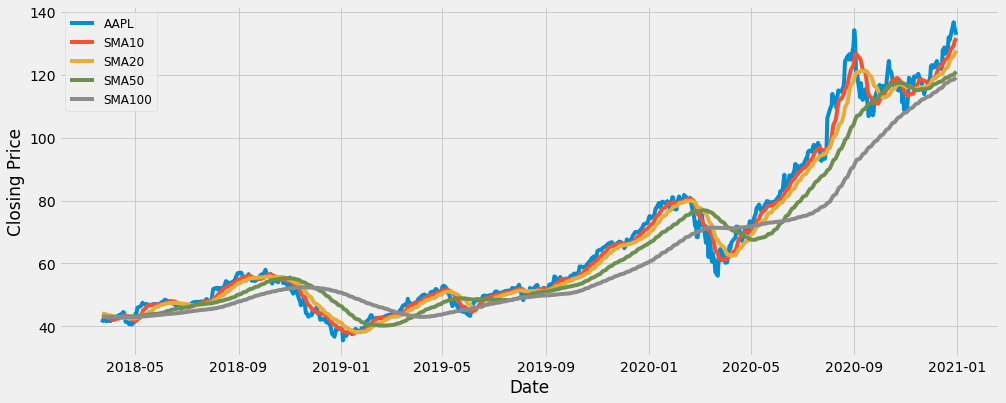

In [6]:
# Visualize the last 700 trading days
plt.figure(figsize=(15, 6))
plt.plot(trading_signals['Close'][-700:], label='AAPL')
plt.plot(SMA10[-700:], label='SMA10')
plt.plot(SMA20[-700:], label='SMA20')
plt.plot(SMA50[-700:], label='SMA50')
plt.plot(SMA100[-700:], label='SMA100')
plt.ylabel("Closing Price")
plt.xlabel("Date")
plt.legend(loc='upper left', fontsize=12)

In [7]:
# Calulate the Short and Long EMA
EMA_short = trading_signals.Close.ewm(span=12, adjust=False).mean()
EMA_long = trading_signals.Close.ewm(span=24, adjust=False).mean()

# Calculate the MACD
MACD = EMA_short - EMA_long

signal = MACD.ewm(span=9, adjust=False).mean()

In [8]:
# Add MACD and Signal to Dataframe
trading_signals["MACD"] = MACD
trading_signals["Signal"] = signal
trading_signals

Close     SMA50      SMA100    Signal  Entry/Exit      MACD
Date                                                                        
2000-01-03    0.999442       NaN         NaN  0.000000         NaN  0.000000
2000-01-04    0.915179       NaN         NaN -0.001244         0.0 -0.006222
2000-01-05    0.928571       NaN         NaN -0.002996         0.0 -0.010001
2000-01-06    0.848214       NaN         NaN -0.006147         0.0 -0.018753
2000-01-07    0.888393       NaN         NaN -0.009392         0.0 -0.022369
...                ...       ...         ...       ...         ...       ...
2020-12-24  131.970001  119.7370  118.223525  2.371598         0.0  2.954454
2020-12-28  136.690002  120.0566  118.489800  2.573684         0.0  3.382025
2020-12-29  134.869995  120.3736  118.699475  2.766716         0.0  3.538848
2020-12-30  133.720001  120.7284  118.925550  2.919863         0.0  3.532450
2020-12-31  132.690002  121.0320  119.125175  3.017477         0.0  3.407932

[5284 rows x 6 columns]

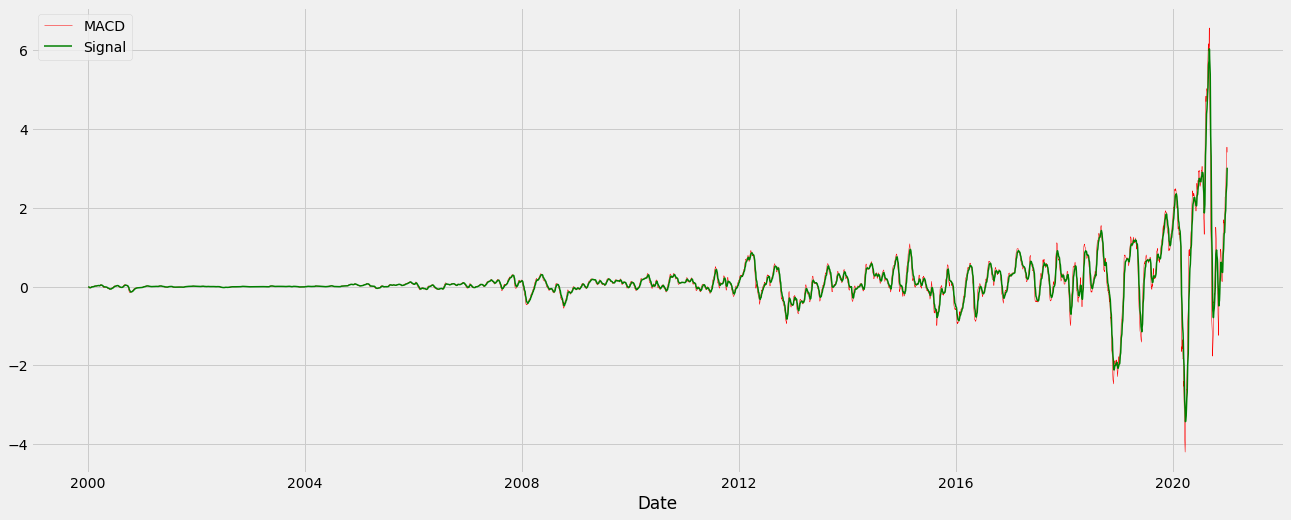

In [9]:
# Plot MACD and Signal
plt.figure(figsize=(20, 8))
plt.plot(trading_signals.index, MACD, label = "MACD", color = "red", linewidth=0.5)
plt.plot(trading_signals.index, signal, label = "Signal", color = "green", linewidth=1.5)
plt.xlabel("Date")
plt.legend(loc = "upper left")
plt.show()

In [10]:
# Define the signal function for entry/exit

def entry_exit(signal):
    Entry = []
    Exit = []
    flag = -1
    
    for i in range(0, len(signal)):
        if signal["MACD"][i] > signal["Signal"][i]:
            Exit.append(np.nan)
            if flag != 1:
                Entry.append(signal["Close"][i])
                flag = 1
            else:
                Entry.append(np.nan)
        elif signal["MACD"][i] < signal["Signal"][i]:
            Entry.append(np.nan)
            if flag != 0:
                Exit.append(signal["Close"][i])
                flag = 0
            else:
                Exit.append(np.nan)
        else:
            Entry.append(np.nan)
            Exit.append(np.nan)
            
    return (Entry, Exit)


In [11]:
# Set the Entry/Exit Column data
data = entry_exit(trading_signals)
trading_signals["Entry_Point"] = data[0]
trading_signals["Exit_Point"] = data[1]

trading_signals

Close     SMA50      SMA100    Signal  Entry/Exit      MACD  \
Date                                                                           
2000-01-03    0.999442       NaN         NaN  0.000000         NaN  0.000000   
2000-01-04    0.915179       NaN         NaN -0.001244         0.0 -0.006222   
2000-01-05    0.928571       NaN         NaN -0.002996         0.0 -0.010001   
2000-01-06    0.848214       NaN         NaN -0.006147         0.0 -0.018753   
2000-01-07    0.888393       NaN         NaN -0.009392         0.0 -0.022369   
...                ...       ...         ...       ...         ...       ...   
2020-12-24  131.970001  119.7370  118.223525  2.371598         0.0  2.954454   
2020-12-28  136.690002  120.0566  118.489800  2.573684         0.0  3.382025   
2020-12-29  134.869995  120.3736  118.699475  2.766716         0.0  3.538848   
2020-12-30  133.720001  120.7284  118.925550  2.919863         0.0  3.532450   
2020-12-31  132.690002  121.0320  119.125175  3.017477         0.0  3.407932   

            Entry_Point  Exit_Point  
Date                                 
2000-01-03          NaN         NaN  
2000-01-04          NaN    0.915179  
2000-01-05          NaN         NaN  
2000-01-06          NaN         NaN  
2000-01-07          NaN         NaN  
...                 ...         ...  
2020-12-24          NaN         NaN  
2020-12-28          NaN         NaN  
2020-12-29          NaN         NaN  
2020-12-30          NaN         NaN  
2020-12-31          NaN         NaN  

[5284 rows x 8 columns]

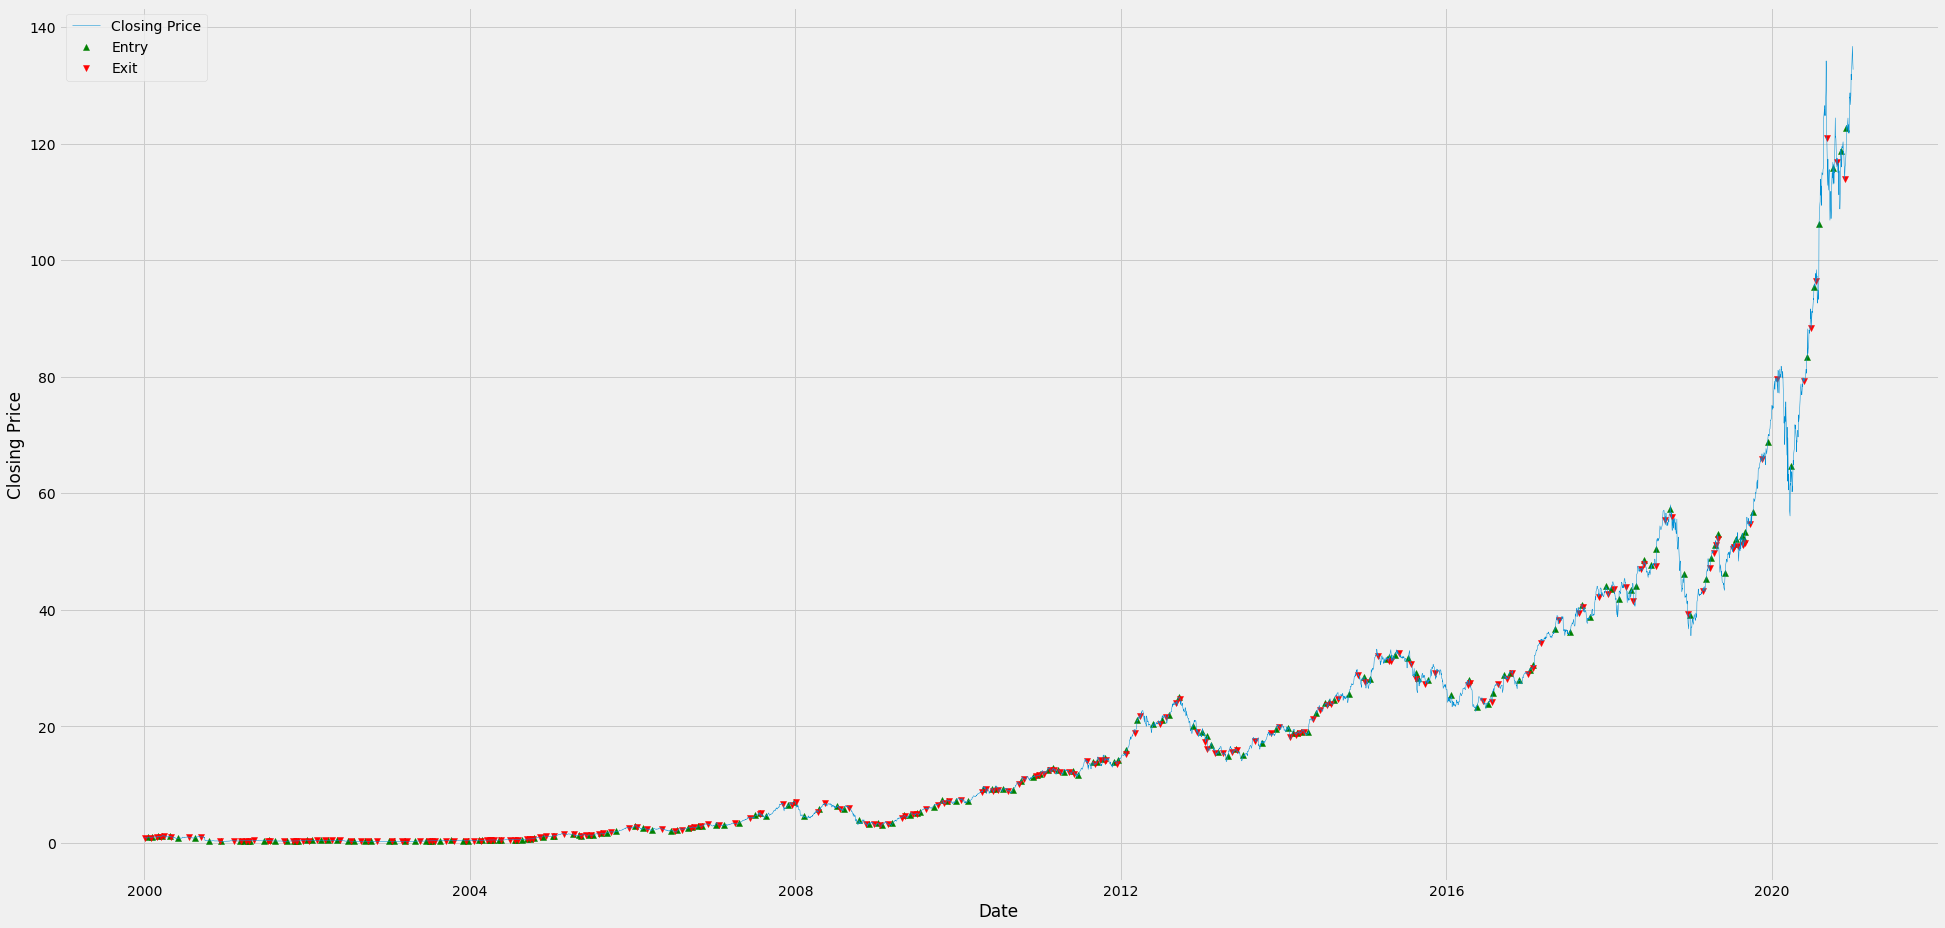

In [17]:
# Visualize the Entry/Exit Point

plt.figure(figsize=(30, 15))
plt.scatter(trading_signals.index, trading_signals["Entry_Point"], color="green", label="Entry", marker="^")
plt.scatter(trading_signals.index, trading_signals["Exit_Point"], color="red", label="Exit", marker="v")
plt.plot(trading_signals["Close"], label="Closing Price", linewidth=0.5)
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend(loc = "upper left")
plt.show()